In [1]:
using Samplers
using Plots

# 1d Ising model

### Metropolis-Hastings verification
Comparison against analytic specific heat
$$ c := \left(\frac{1 }{T \cdot \cosh ( 1 / T)}\right)^2 $$

In [2]:
function populate_E_E2!(
    im::T,
    acc::Measurements.Accumulator,
    nsweeps::Int=10^3,
    ntherm::Int=10^4, 
    meas_interval::Int=10^2,
    alg::Symbol = :Metropolis,
) where {T <: IsingModel}
    @assert mod(nsweeps, meas_interval) == 0
    
    # thermalization steps
    if alg == :Metropolis
        Metropolis!(im, ntherm)
    else
        Wolff!(im, ntherm)
    end
    
    # Measurement sweeps
    @inbounds for imeas in 1:(nsweeps/meas_interval)
        Metropolis!(im, meas_interval)
        Measurements.add!(acc, "E", Float64(im.energy))
        Measurements.add!(acc, "E2", Float64((im.energy)^2))
    end
end

populate_E_E2! (generic function with 5 methods)

In [57]:
# NOTE: Takes about 2 minutes.
Ts = range(0.1, 2, length=100)
exact_C(T) = 1/(T * cosh(1/T))^2

Ts_mc = range(0.4, 2, length=10)
C_mc = Float64[]
@inbounds for T in Ts_mc
    im = Periodic_1d(250, T)
    acc = Measurements.Accumulator()
    populate_E_E2!(im, acc, 10^4, 10^3, 10)
    E = Measurements.mean(acc, "E")
    E2 = Measurements.mean(acc, "E2")
    push!(C_mc, (E2 - E^2)/T^2)
end

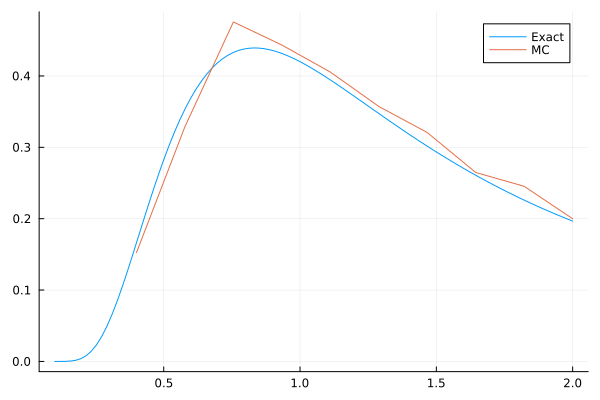

In [58]:
# Note: not perfect, however, spending more time ensuring equilibration/ accumulating observations
#   brings it much closer. ie, better plot if you increase the 3rd and 4th arguments to populate_E_E2!(...)
#   in the cell just above this. For 10^5 and 10^4, it is very close but the cell takes about 2 minutes.
# Note also that the orange line (MC simulation) is interpolating 10 points.
plot(Ts, exact_C.(Ts), label="Exact")
plot!(Ts_mc, C_mc ./ 250, label="MC")

In [65]:
using Statistics
residuals = abs.(((C_mc./250) - exact_C.(Ts_mc)))
println("Mean Error: ", Statistics.mean(residuals))
sq_residuals = abs.(((C_mc./250) - exact_C.(Ts_mc)).^2)
println("Mean Square Error: ", Statistics.mean(sq_residuals))

Mean Error: 0.021662056073429584


Mean Square Error: 0.0008023332396400703


### Wolff 1d verification.

Same test.

In [66]:
# NOTE: also takes about two minutes
Ts = range(0.1, 2, length=100)
exact_C(T) = 1/(T * cosh(1/T))^2

Ts_mc = range(0.4, 2, length=10)
C_mc = Float64[]
@inbounds for T in Ts_mc
    im = Periodic_1d(250, T)
    acc = Measurements.Accumulator()
    populate_E_E2!(im, acc, 10^4, 10^3, 10, :Wolff)
    E = Measurements.mean(acc, "E")
    E2 = Measurements.mean(acc, "E2")
    push!(C_mc, (E2 - E^2)/T^2)
end

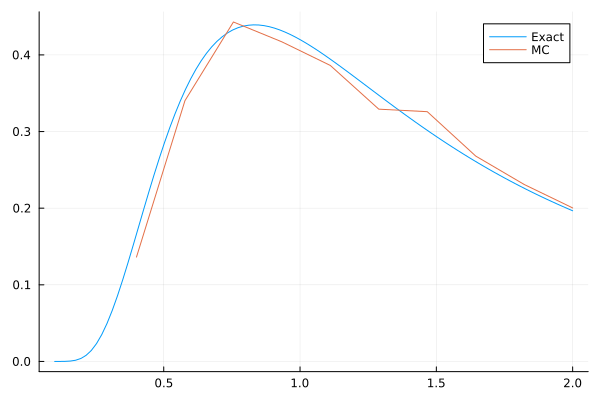

In [67]:
# N.B. same deal.
plot(Ts, exact_C.(Ts), label="Exact")
plot!(Ts_mc, C_mc ./ 250, label="MC")

In [68]:
residuals = abs.(((C_mc./250) - exact_C.(Ts_mc)))
println("Mean Error: ", Statistics.mean(residuals))
sq_residuals = abs.(((C_mc./250) - exact_C.(Ts_mc)).^2)
println("Mean Square Error: ", Statistics.mean(sq_residuals))

Mean Error: 0.013419772212256108
Mean Square Error: 0.0002465863769289616


# 2d Verification
Plots and analytic comparison.

In [18]:
# Metropolis visualizations; took 1m49s.
im1 = Periodic_2d(250, 0.0003)
im2 = Periodic_2d(250, 1.5)
im3 = Periodic_2d(250, 2.15)
im4 = Periodic_2d(250, 4.0)
im5 = Periodic_2d(250, 100.0)

Metropolis!(im1, 1000)
Metropolis!(im2, 1000)
Metropolis!(im3, 1000)
Metropolis!(im4, 1000)
Metropolis!(im5, 1000)

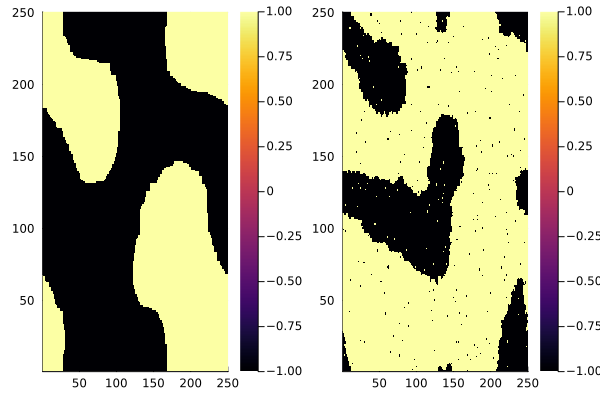

In [20]:
# Well below critical temperature
p1 = heatmap(im1.state)
# Below critical temperature
p2 = heatmap(im2.state)

l = @layout [a b]
plot(p1,p2, layout=l)

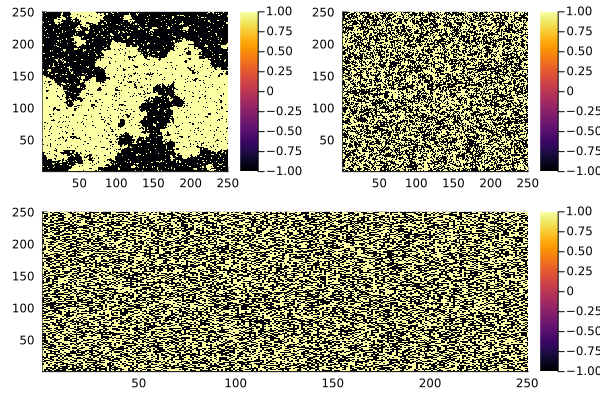

In [19]:
# Just a touch below critical temperature
p3 = heatmap(im3.state)
# A bit above the critical temperature
p4 = heatmap(im4.state)
# Well, well above critical temperature
p5 = heatmap(im5.state)

l = @layout [a b ; c]
plot(p3,p4,p5, layout=l)

In [12]:
# Now, with Wolff; took 2m16s
im1 = Periodic_2d(250, 0.0003)
im2 = Periodic_2d(250, 1.5)
im3 = Periodic_2d(250, 2.15)
im4 = Periodic_2d(250, 4.0)
im5 = Periodic_2d(250, 100.0)

Wolff!(im1, 100)
Wolff!(im2, 1000)
Wolff!(im3, 10000)
Wolff!(im4, 1000)
Wolff!(im5, 100)

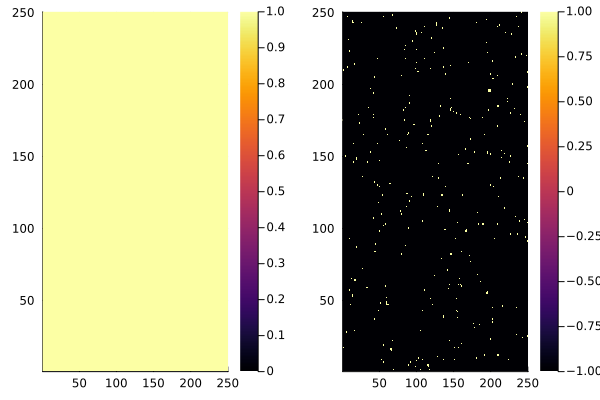

In [10]:
# Well below critical temperature
p1 = heatmap(im1.state)
# Below critical temperature
p2 = heatmap(im2.state)

l = @layout [a b]
plot(p1,p2, layout=l)

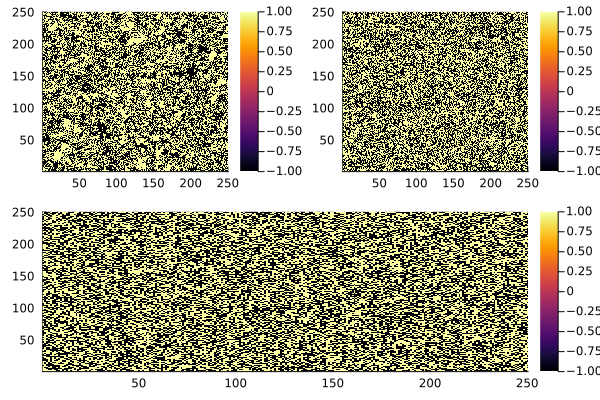

In [11]:
# Just a touch below critical temperature
p3 = heatmap(im3.state)
# A bit above the critical temperature
p4 = heatmap(im4.state)
# Well, well above critical temperature
p5 = heatmap(im5.state)

l = @layout [a b ; c]
plot(p3,p4,p5, layout=l)

In [85]:
using SpecialFunctions
L = 1.5
R = 3.0

Ts = range(L, R, length=100)
function exact_C_2d(beta::T) where {T <: AbstractFloat}
    k = 2 * tanh(2 * beta) / cosh(2 * beta)
    K = ellipk(k^2)
    E = ellipe(k^2)
    j = 2 * tanh(2 * beta)^2 - 1
    return beta^2 * coth(2*beta)^2 * (2/π) * (((j - 1//2)^2 + 7//4) * K - 2E - (1 - j) * π / 2)
end

exact_C_2d (generic function with 1 method)

In [93]:
Ts_mc = range(L, R, length=10)
C_mc = Float64[]
# Takes approx. 2 minutes to run the below. Note small lattice and maybe not enough time for equilibration.
@inbounds for T in Ts_mc
    im = Periodic_2d(60, T)
    acc = Measurements.Accumulator()
    populate_E_E2!(im, acc, 10^3, 10^4, 5, :Metropolis)
    E = Measurements.mean(acc, "E")
    E2 = Measurements.mean(acc, "E2")
    push!(C_mc, (E2 - E^2)/T^2)
end

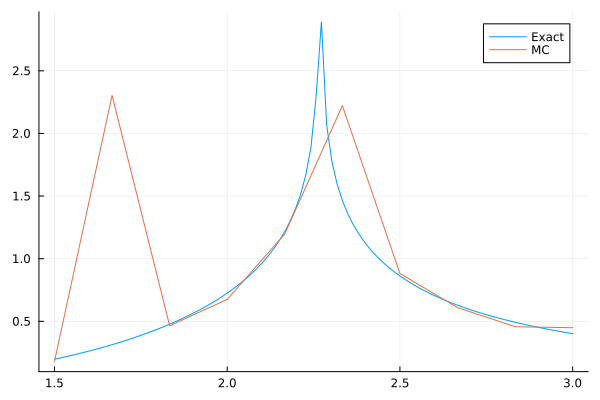

In [95]:
plot(Ts, (exact_C_2d.(1 ./ Ts)), label="Exact")
plot!(Ts_mc, (C_mc ./ 60^2), label="MC")

In [106]:
residuals = abs.(((C_mc./3600) - exact_C_2d.(Ts_mc)))
println("Mean Error: ", Statistics.mean(residuals))
sq_residuals = ((C_mc./3600) - exact_C_2d.(Ts_mc)).^2
println("Mean Square Error: ", Statistics.mean(sq_residuals))

Mean Error: 0.6855038289117034
Mean Square Error: 0.6702044236245446


In [101]:
Ts_mc = range(L, R, length=10)
C_mc = Float64[]
@inbounds for T in Ts_mc
    im = Periodic_2d(60, T)
    acc = Measurements.Accumulator()
    populate_E_E2!(im, acc, 10^3, 10^4, 5, :Wolff)
    E = Measurements.mean(acc, "E")
    E2 = Measurements.mean(acc, "E2")
    push!(C_mc, (E2 - E^2)/T^2)
end

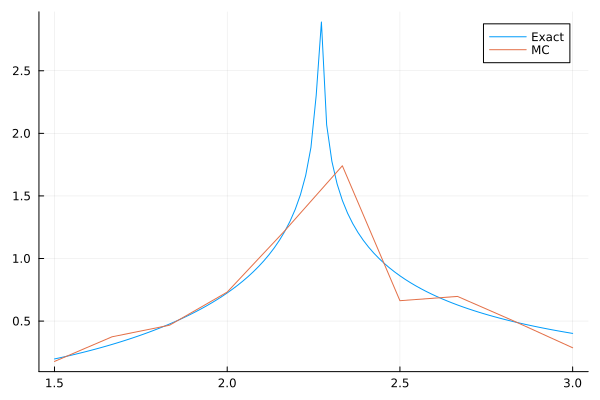

In [102]:
plot(Ts, (exact_C_2d.(1 ./ Ts)), label="Exact")
plot!(Ts_mc, (C_mc ./ 60^2), label="MC")

In [105]:
residuals = abs.(((C_mc./3600) - exact_C_2d.(Ts_mc)))
println("Mean Error: ", Statistics.mean(residuals))
sq_residuals = ((C_mc./3600) - exact_C_2d.(Ts_mc)).^2
println("Mean Square Error: ", Statistics.mean(sq_residuals))

Mean Error: 0.6855038289117034
Mean Square Error: 0.6702044236245446
